In [1]:
using WignerSymbols, PyPlot, LaTeXStrings, DelimitedFiles, LinearAlgebra
using PyCall
LineCollection = matplotlib.collections.LineCollection

PyObject <class 'matplotlib.collections.LineCollection'>

# Dysprosium polarizability using the lines of [Li et al.](https://iopscience.iop.org/article/10.1088/1361-6455/50/1/014005/meta?casa_token=fdHnA09HK5YAAAAA:udMr6w5uNeI5ymUbqNnQTZblKQiRSeYYoepYsFGMrxY2bt5KqtGu9WEa6M7q-kmo-hczrc5g)

In [2]:
const mₑ = 9.109E-31
const c = 2.997E8
const ħ = 1.05457E-34
const e = 1.6022E-19
const a₀ = 5.29177E-11
const ϵ₀ = 8.8542E-12
const au_pol = 1.65E-41
const Eh = ħ^2 / (mₑ * a₀^2)    # Hartree energy
const Ia = 0;                  # Nuclear spin
const mdy=161.926805*1.6605*1e-27;

In [3]:
toω(λ) = 2*π*137 / λ   # in a.u.


toω (generic function with 1 method)

The reduced matrix element depends on the oscillator strength $A_{ik}$ through

$|\langle n'J' || \mathbf{d} || nJ \rangle |^2 = \frac{3\pi\epsilon_0\hbar c^3}{\omega_{ik}^3} (2J' + 1) A_{ik}.$

The oscillator strengths can be obtained through the [NIST database](https://physics.nist.gov/cgi-bin/ASD/lines_hold.pl?el=Dy) (click "Dy I," they're labeled $A_{ki}$ in that table).

Following the conventions of Le Kien and other literature, we absorb $\sqrt{2J+1}$ into the reduced matrix element.

In [4]:
linesdat = readdlm("5I8_Spectre_Eexp-2.txt", ',', Float64);
linesdat = sortslices(linesdat, dims = 1, lt = (x, y) -> isless(x[4], y[4]), rev = true);

In [5]:
Jps = linesdat[:, 2]
Js = linesdat[:, 1]
Γs = linesdat[:, 5]
λs = 2*π * 137 ./ linesdat[:, 3]
redMatEls = sqrt.( linesdat[:, 4] );


In [6]:
function α(K, J, ω)
    prefac = Complex(-1)^(K + J + 1) * sqrt(2*K + 1)
    terms = [Complex(-1)^Jp * wigner6j(1, K, 1, J, Jp, J) * redMatEl^2 * ( 1/(toω(λ) - ω - 1im * γ/2) + (-1)^K/(toω(λ) + ω + 1im * γ/2) ) for (Jp, redMatEl, λ, γ) ∈ zip(Jps, redMatEls, λs, Γs) ]
    s = sum(terms)
    return (prefac * s)
end

α (generic function with 1 method)

In [7]:
αs(ω) = 1/sqrt(3 * (2*Js[1] + 1) ) * α(0, Js[1], ω) 
αv(ω) = sqrt(2*Js[1] / ( (Js[1] + 1)*(2*Js[1] + 1) )) * α(1, Js[1], ω)  #vector shift这里应该有负号吗？？
αt(ω) = -sqrt( 2*Js[1] * (2*Js[1] - 1) / ( 3*(Js[1] + 1) * (2*Js[1] + 1) * (2*Js[1] + 3) ) ) * α(2, Js[1], ω)

αt (generic function with 1 method)

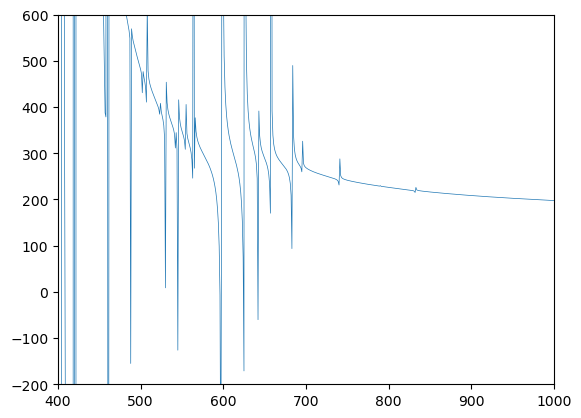

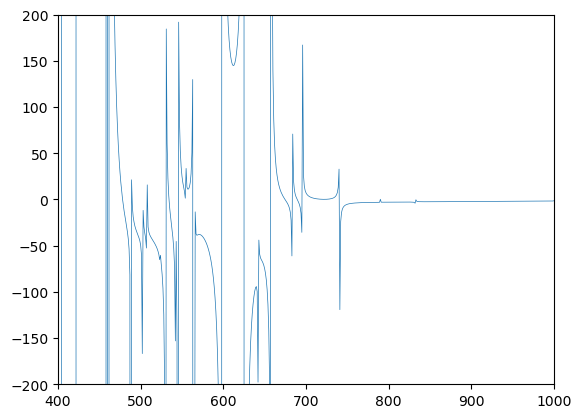

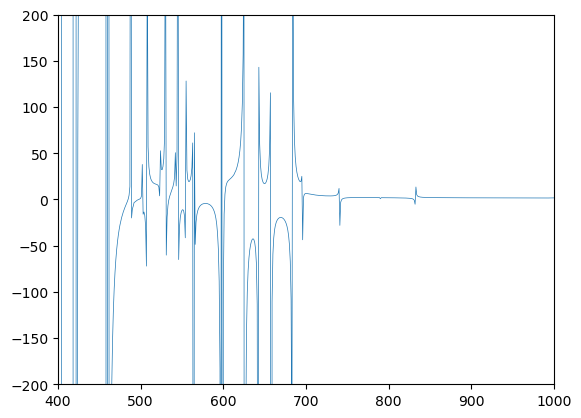

(400.0, 1000.0)

In [8]:
fig, ax = plt.subplots()
λsp = [400:1:1000;]*1e-9

ax.plot(λsp * 1e9, real.([αs(toω(λ / a₀)) for λ ∈ λsp]), label = "Us", lw = 0.5)
ax.set_ylim([-200, 600])
ax.set_xlim([400, 1000])

fig, ax = plt.subplots()

ax.plot(1e9 .* λsp, real.([αv(toω(λ / a₀)) for λ ∈ λsp]), lw = 0.5, label = "Us - vector")
ax.set_ylim([-200, 200])
ax.set_xlim([400, 1000])

fig, ax = plt.subplots()
tensor_pols = [αt(toω(λ / a₀)) for λ ∈ λsp]
ax.plot((λsp * 1e9), real.(tensor_pols), lw = 0.5, label = "Us - vector")
ax.set_ylim([-200, 200])
ax.set_xlim([400, 1000])


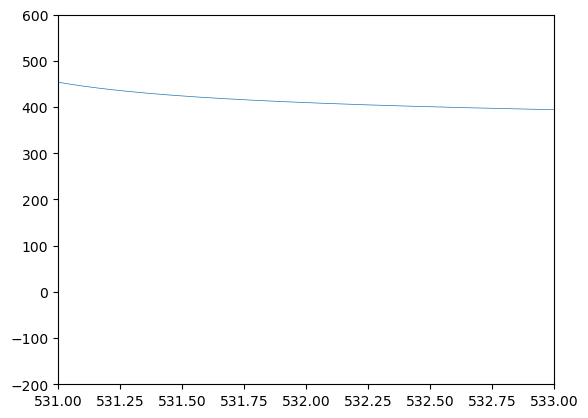

(531.0, 533.0)

In [11]:
fig, ax = plt.subplots()
λsp = [531:0.01:533;]*1e-9

ax.plot(λsp * 1e9, real.([αs(toω(λ / a₀)) for λ ∈ λsp]), label = "Us", lw = 0.5)
ax.set_ylim([-200, 600])
ax.set_xlim([531, 533])


## Define different functions

In [9]:
function uu(K, q, pol)
    function sumterm(K, q, μ, μp, pol)
        # Check if CG is physical
        if μ - q + μp == 0
            Complex(-1)^(q + μp) * pol[μ + 2] * conj(pol[2 - μp]) * sqrt(2*K + 1)  * wigner3j(1, K, 1, μ, -q, μp)
        else
            0
        end
    end
    return sum([sumterm(K, q, μ, μp, pol) for μ ∈ (-1, 0, 1) for μp in (-1, 0, 1)])
end

function α_tot(ω, J, mJ, Jp, mJp, pol; Kmax = 2)
    if abs(mJ - mJp) > 2
        return 0.0
    else
        return real(sum([ α(K, J, ω) * uu(K, q, pol) * Complex(-1)^(J + Ia + K + q - mJ) *
            sqrt((2*J + 1) * (2*Jp + 1)) * wigner3j(J, K, Jp, mJ, q, -mJp) *
            wigner6j(J, K, Jp, J, Ia, J) for K ∈ [0:Kmax;] for q ∈ [-K:K;]]))
    end
end

function α_tot_precalc(αs, J, mJ, Jp, mJp, pol; Kmax = 2)
    # Same as above, but requires α(K, J, ω) to be precalculated, feed in as array [α(0, J, ω), ..., α(2, J, ω)]
    if abs(mJ - mJp) > 2
        return 0.0
    else
        return real(sum([ αs[K + 1] * uu(K, q, pol) * Complex(-1)^(J + Ia + K + q - mJ) *
            sqrt((2*J + 1) * (2*Jp + 1)) * wigner3j(J, K, Jp, mJ, q, -mJp) *
            wigner6j(J, K, Jp, J, Ia, J) for K ∈ [0:Kmax;] for q ∈ [-K:K;]]))
    end
end

α_tot_precalc (generic function with 1 method)

In [10]:
function normalized_polarization_eigenstates(ω, pol; Kmax = 2, offdiag = true, return_vecs = false)
    αmat = zeros(17, 17)
    αs = [α(K, 8, ω) for K ∈ 0:2]
    for (i, mJ) ∈ enumerate(-8:8)
        for (j, mJp) ∈ enumerate(mJ:8)
            αmat[i, i+j-1] = α_tot_precalc(αs, 8, mJ, 8, mJp, pol; Kmax = Kmax)
        end
    end
    if offdiag
        if return_vecs
            return eigen(Symmetric(αmat, :U)) #Construct a Symmetric view of the upper 
                                               #(if uplo = :U) or lower (if uplo = :L) triangle of the matrix A.
        else
            return eigvals(Symmetric(αmat, :U))
        end
    else
        return diag(αmat)
    end
end

normalized_polarization_eigenstates (generic function with 1 method)

In [19]:
λ₀ = λs[1] * a₀

7.407704310604077e-7

In [11]:
λrange = range(740.74e-9, 740.8e-9, length = 200)

fig, ax = plt.subplots()
for mJ in [-8,8]
    ax.plot(c*(1 ./ λrange .- 1 ./ λ₀ ) ./ 1e9, [α_tot(toω(λ / a₀), 8, mJ, 8, mJ, [1, 0, 0]) for λ ∈ λrange], label = string(L"m_J =", mJ))
end

ax.set_xlabel("Δ/2π (GHz)", fontsize = 12)
ax.set_ylabel("Polarizability (a.u.)", fontsize = 12)
ax.set_title(L"Polarizability in $\sigma_+$ light around the 741 nm transition")
ax.legend()
ax.set_ylim([-1000, 0])

LoadError: UndefVarError: λ₀ not defined

In [8]:
latwavelength = c/(c/(740.7704310604076e-9) - 1.25e9);

latwavelength = 532e-9

5.32e-7

In [9]:
println(αs(toω(latwavelength / a₀)));

println(αv(toω(latwavelength / a₀)));

println(αt(toω(latwavelength / a₀)));


409.6716891199573 + 3.3136973189300375e-5im
60.60904324859908 - 1.3877136451590074e-5im
-19.17048564284766 + 4.229913767720922e-6im


In [ ]:
4406.905161287171 + 0.0031360650294428405im
-11751.710788179029 - 0.00836284007855416im
-3092.5650254646816 - 0.0022007473890826956im

In [24]:
αp(Kmax) = [α_tot(toω(latwavelength / a₀), 8, mJ, 8, mJ, [1, 0, 0], Kmax = Kmax) for mJ ∈ [-8:8;]]
αm(Kmax) = [α_tot(toω(latwavelength / a₀), 8, mJ, 8, mJ, [0, 0, 1], Kmax = Kmax) for mJ ∈ [-8:8;]];

In [13]:
function get_levels(σp_beam, σm_beam; Kmax = 2, offdiag = true, return_vecs = false)
    levels = zeros(length(σp_beam), 17)
    expsz = zeros(length(σp_beam), 17)
    for i ∈ 1:length(σp_beam)
        pol = [σp_beam[i], 0, σm_beam[i]]
        pol = pol/norm(pol)
        if return_vecs
            vals, vecs = normalized_polarization_eigenstates(toω(latwavelength / a₀), pol; Kmax = Kmax, offdiag = offdiag, return_vecs = return_vecs)  
            levels[i, :] = (σp_beam[i]^2 + σm_beam[i]^2) * vals
            #levels[i, :] = (σp_beam[i] + σm_beam[i]) * vals   # I changed this equation, because I think sigma_p/m should be electric field?
            expsz[i, :] = abs.(vecs.^2)'*[-8.:1.:8.;]
        else
            levels[i, :] = (σp_beam[i]^2 + σm_beam[i]^2) * normalized_polarization_eigenstates(toω(latwavelength / a₀), pol; Kmax = Kmax, offdiag = offdiag, return_vecs = return_vecs)
        end
    end
    
    if return_vecs
        return levels, expsz
    else
        return levels
    end
end



get_levels (generic function with 1 method)

## Lattice cartoon

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


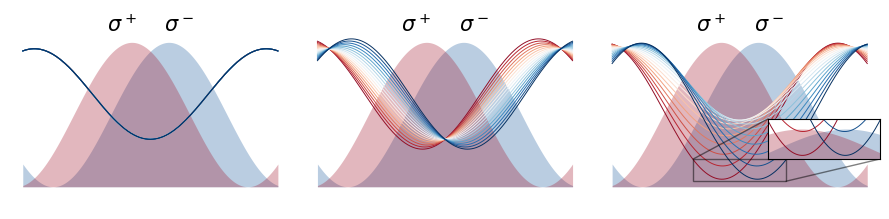

In [14]:
fig, ax = plt.subplots(1, 3, figsize = (9, 2.3), sharex = true)
ax = vcat(permutedims(ax)...)
cmap = matplotlib.cm.get_cmap("RdBu");

#axinss = [ax[i].inset_axes([0.75, 0.25, 0.4, 0.4]) for i in [2, 4]]
axinss = [ax[i].inset_axes([0.6, 0.25, 0.4, 0.2]) for i in [3]]
axinss[1].set_ylim([-12500, -10500])
#axinss[2].set_ylim([-10000, -6000])
#axinss[2].set_ylim([-13000, -9000])


for (i, axins) ∈ enumerate(axinss)
    axins.set_xlim([-0.4, 0.4])
    axins.set_yticks([])
    axins.set_xticks([])
end

xdum = range(-1.1, 1.1, length = 1000) #20
#σp_beam = cos.(π*xdum/2 .- π/40)
#σm_beam = cos.(π*xdum/2 .+ π/40)

σp_beam = cos.(π*xdum/2 .- π*0.08)
σm_beam = cos.(π*xdum/2 .+ π*0.08)


potentials = get_levels(σp_beam, σm_beam; Kmax = 0, offdiag = false)
[ax[1].plot(xdum, p, c = cmap(i/17), lw = 0.7) for (i, p) ∈ enumerate(eachrow(potentials'))]

potentials = get_levels(σp_beam, σm_beam; Kmax = 1, offdiag = false)
[ax[2].plot(xdum, p, c = cmap(i/17), lw = 0.7) for (i, p) ∈ enumerate(eachrow(potentials'))]
#[axinss[1].plot(xdum, p, c = cmap(i/17), lw = 0.7) for (i, p) ∈ enumerate(eachrow(potentials'))]

potentials = get_levels(σp_beam, σm_beam; Kmax = 2, offdiag = false)
[ax[3].plot(xdum, p, c = cmap(i/17), lw = 0.7) for (i, p) ∈ enumerate(eachrow(potentials'))]
[axinss[1].plot(xdum, p, c = cmap(i/17), lw = 0.7) for (i, p) ∈ enumerate(eachrow(potentials'))]


#potentials, szexp = get_levels(σp_beam, σm_beam; Kmax = 2, offdiag = true, return_vecs = true)
#for (i, p) ∈ enumerate(eachrow(potentials'))
#    a = [xdum p]
#    linecol = cat(a[1:(end-1), :], a[2:end, :], dims = 3)
#    linecol = permutedims(linecol, [1, 3, 2])
#    lc = LineCollection(linecol, colors = cmap.(szexp[:, i]/16.0 .+ 0.5), lw = 0.7)
#    ax[4].add_collection(lc)
#    lc = LineCollection(linecol, colors = cmap.(szexp[:, i]/16.0 .+ 0.5), lw = 0.7)
#    axinss[1].add_collection(lc)
#end



for i ∈ 1:length(ax)
    ax[i].fill_between(xdum, -1.3e4, σp_beam.^2*1.3e4 .- 1.3e4, color = cmap(235), alpha = 0.3, lw = 0) #cmap(235)
    ax[i].fill_between(xdum, -1.3e4, σm_beam.^2*1.3e4 .- 1.3e4, color = cmap(20), alpha = 0.3, lw = 0) #cmap(20)
    ax[i].set_yticks([])
    ax[i].set_xticks([])
    ax[i].axis("off")
    ax[i].text(-(0.25), 1000, L"\sigma^+", horizontalalignment = "center", fontsize = 15)
    ax[i].text(0.25, 1000, L"\sigma^-", horizontalalignment = "center", fontsize = 15)
    ax[i].set_ylim([-15000, 3000])
end
    
axinss[1].fill_between(xdum, -1.3e4, σp_beam.^2*0.2e4 .- 1.3e4, color = cmap(235), alpha = 0.3, lw = 0)
axinss[1].fill_between(xdum, -1.3e4, σm_beam.^2*0.2e4 .- 1.3e4, color = cmap(20), alpha = 0.3, lw = 0) #cmap(20)


ax[3].indicate_inset_zoom(axinss[1], edgecolor = "black")

fig.tight_layout()
fig.subplots_adjust(hspace = 0.05, wspace = 0.05)
fig.savefig("tweezer_cartoon.eps",format="eps")

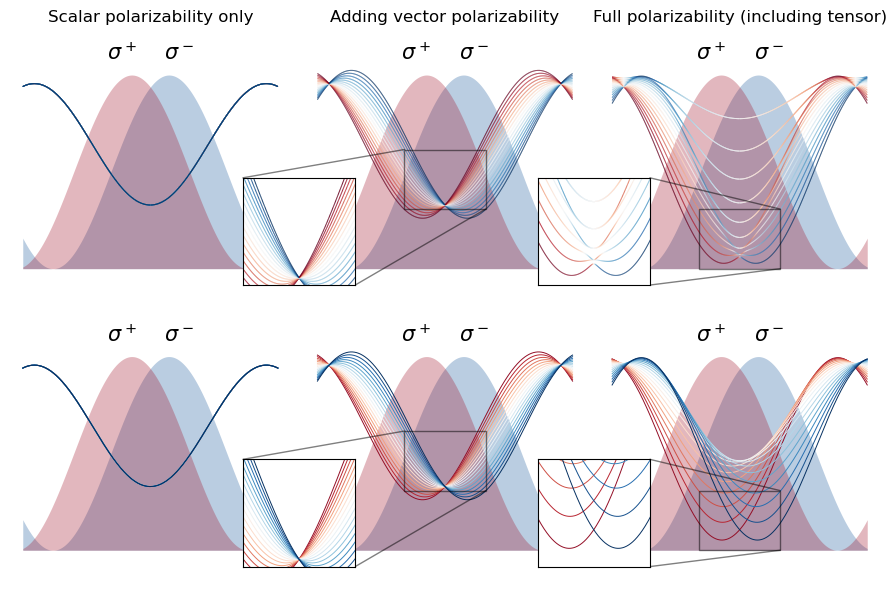

In [31]:
fig, ax = plt.subplots(2, 3, figsize = (9, 6), sharex = true)
ax = vcat(permutedims(ax)...)
cmap = matplotlib.cm.get_cmap("RdBu");

axinss = [ax[i].inset_axes([-0.22, 0.05, 0.4, 0.4]) for i in [2, 3, 5, 6]]
axinss[1].set_ylim([-9000, -5000])
axinss[2].set_ylim([-13000, -9000])
axinss[3].set_ylim([-9000, -5000])
axinss[4].set_ylim([-13000, -9000])

for (i, axins) ∈ enumerate(axinss)
    axins.set_xlim([-0.35, 0.35])
    axins.set_yticks([])
    axins.set_xticks([])
end

xdum = range(-1.1, 1.1, length = 1000) #20
σp_beam = cos.(π*xdum/2 .- π/24)
σm_beam = cos.(π*xdum/2 .+ π/24)

for (k, Kmax) ∈ enumerate([0:2;])
    potentials, szexp = get_levels(σp_beam, σm_beam; Kmax = Kmax, offdiag = true, return_vecs = true)
    for (i, p) ∈ enumerate(eachrow(potentials'))
        a = [xdum p]
        linecol = cat(a[1:(end-1), :], a[2:end, :], dims = 3)
        linecol = permutedims(linecol, [1, 3, 2])
        lc = LineCollection(linecol, colors = cmap.(szexp[:, i]/16.0 .+ 0.5), lw = 0.7)
        ax[k].add_collection(lc)
        if k > 1
            lc = LineCollection(linecol, colors = cmap.(szexp[:, i]/16.0 .+ 0.5), lw = 0.7)
            axinss[k-1].add_collection(lc)
        end
    end
end

for (k, Kmax) ∈ enumerate([0:2;])
    potentials = get_levels(σp_beam, σm_beam; Kmax = Kmax, offdiag = false)
    [ax[k + 3].plot(xdum, p, c = cmap(i/17), lw = 0.7) for (i, p) ∈ enumerate(eachrow(potentials'))]
    if k > 1
        [axinss[k + 1].plot(xdum, p, c = cmap(i/17), lw = 0.7) for (i, p) ∈ enumerate(eachrow(potentials'))]
    end
end

for i ∈ 1:length(ax)
    ax[i].fill_between(xdum, -1.3e4, σp_beam.^2*1.3e4 .- 1.3e4, color = cmap(235), alpha = 0.3, lw = 0) #cmap(235)
    ax[i].fill_between(xdum, -1.3e4, σm_beam.^2*1.3e4 .- 1.3e4, color = cmap(20), alpha = 0.3, lw = 0) #cmap(20)
    ax[i].set_yticks([])
    ax[i].set_xticks([])
    ax[i].axis("off")
    ax[i].text(-(0.25), 1000, L"\sigma^+", horizontalalignment = "center", fontsize = 15)
    ax[i].text(0.25, 1000, L"\sigma^-", horizontalalignment = "center", fontsize = 15)
    ax[i].set_ylim([-15000, 3000])
end
    
ax[1].set_title("Scalar polarizability only")
ax[2].set_title("Adding vector polarizability")
ax[3].set_title("Full polarizability (including tensor)")

ax[1].set_ylabel("Same frequency traps", fontsize = 13)
ax[4].set_ylabel("Different frequency traps", fontsize = 13)

ax[2].indicate_inset_zoom(axinss[1], edgecolor = "black")
ax[3].indicate_inset_zoom(axinss[2], edgecolor = "black")
ax[5].indicate_inset_zoom(axinss[3], edgecolor = "black")
ax[6].indicate_inset_zoom(axinss[4], edgecolor = "black")

fig.tight_layout()
fig.subplots_adjust(hspace = 0.05, wspace = 0.05)
# fig.savefig("tweezer_cartoon.png", dpi = 300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


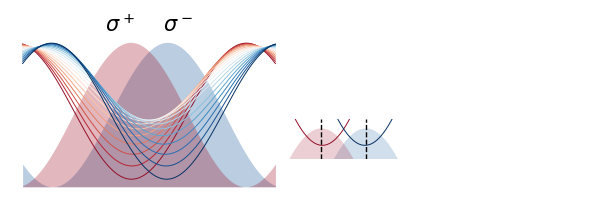

In [54]:
fig, ax = plt.subplots(1,2,figsize = (6, 2.3),sharex=true)
ax = vcat(permutedims(ax)...)
cmap = matplotlib.cm.get_cmap("RdBu");

#axinss = [ax[i].inset_axes([0.75, 0.25, 0.4, 0.4]) for i in [2, 4]]
axinss = [ax[i].inset_axes([1, 0.25, 0.4, 0.2]) for i in [1]]
axinss[1].set_ylim([-12900, -11200])
#axinss[1].set_ylim([-12700, -11000])


for (i, axins) ∈ enumerate(axinss)
    axins.set_xlim([-0.4, 0.4])
    axins.set_yticks([])
    axins.set_xticks([])
end

sep=0.16# separation of the electric field

xdum = range(-1.1, 1.1, length = 1000) #20
σp_beam = cos.(π*xdum/2 .- π*sep/2)
σm_beam = cos.(π*xdum/2 .+ π*sep/2)



potentials = get_levels(σp_beam, σm_beam; Kmax = 2, offdiag = false)
[ax[1].plot(xdum, p, c = cmap(i/17), lw = 0.7) for (i, p) ∈ enumerate(eachrow(potentials'))]
[axinss[1].plot(xdum, p, c = cmap(i/17), lw = 0.7) for (i, p) ∈ enumerate(eachrow(potentials'))]

l1=axinss[1].axvline(-sep,color="black",ls="--",lw=1)
l1=axinss[1].axvline(+sep,color="black",ls="--",lw=1)


ax[1].fill_between(xdum, -1.3e4, σp_beam.^2*1.3e4 .- 1.3e4, color = cmap(235), alpha = 0.3, lw = 0) #cmap(235)
ax[1].fill_between(xdum, -1.3e4, σm_beam.^2*1.3e4 .- 1.3e4, color = cmap(20), alpha = 0.3, lw = 0) #cmap(20)
ax[1].set_yticks([])
ax[1].set_xticks([])
ax[1].axis("off")

ax[2].set_yticks([])
ax[2].set_xticks([])
ax[2].axis("off")

ax[1].text(-(0.25), 1000, L"\sigma^+", horizontalalignment = "center", fontsize = 15)
ax[1].text(0.25, 1000, L"\sigma^-", horizontalalignment = "center", fontsize = 15)
ax[1].set_ylim([-15000, 3000])


axinss[1].fill_between(xdum[300:700], -2.2e4, σp_beam[300:700].^2*1.04e4 .- 2.2e4, color = cmap(235), alpha = 0.2, lw = 0)
axinss[1].fill_between(xdum[300:700], -2.2e4, σm_beam[300:700].^2*1.04e4 .- 2.2e4, color = cmap(20), alpha = 0.2, lw = 0) #cmap(20)
axinss[1].axis("off")

#ax[1].indicate_inset_zoom(axinss[1], edgecolor = "black")

fig.tight_layout()
fig.subplots_adjust(hspace = 0.05, wspace = 0.05)
fig.savefig("diffreq_1205_1.eps",format="eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


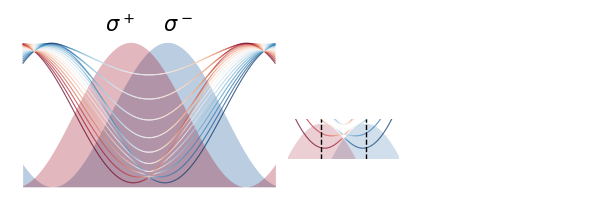

In [53]:
fig, ax = plt.subplots(1,2,figsize = (6, 2.3),sharex=true)
ax = vcat(permutedims(ax)...)
cmap = matplotlib.cm.get_cmap("RdBu");

#axinss = [ax[i].inset_axes([0.75, 0.25, 0.4, 0.4]) for i in [2, 4]]
axinss = [ax[i].inset_axes([1, 0.25, 0.4, 0.2]) for i in [1]]
axinss[1].set_ylim([-13100, -11400])
#axinss[2].set_ylim([-10000, -6000])
#axinss[2].set_ylim([-13000, -9000])


for (i, axins) ∈ enumerate(axinss)
    axins.set_xlim([-0.4, 0.4])
    axins.set_yticks([])
    axins.set_xticks([])
end

sep=0.16# separation of the electric field

xdum = range(-1.1, 1.1, length = 1000) #20
σp_beam = cos.(π*xdum/2 .- π*sep/2)
σm_beam = cos.(π*xdum/2 .+ π*sep/2)



potentials, szexp = get_levels(σp_beam, σm_beam; Kmax = 2, offdiag = true, return_vecs = true)
for (i, p) ∈ enumerate(eachrow(potentials'))
    a = [xdum p]
    linecol = cat(a[1:(end-1), :], a[2:end, :], dims = 3)
    linecol = permutedims(linecol, [1, 3, 2])
    lc = LineCollection(linecol, colors = cmap.(szexp[:, i]/16.0 .+ 0.5), lw = 0.7)
    ax[1].add_collection(lc)
    lc = LineCollection(linecol, colors = cmap.(szexp[:, i]/16.0 .+ 0.5), lw = 0.7)
    axinss[1].add_collection(lc)    
end

l1=axinss[1].axvline(-sep,color="black",ls="--",lw=1)
l1=axinss[1].axvline(+sep,color="black",ls="--",lw=1)


ax[1].fill_between(xdum, -1.3e4, σp_beam.^2*1.3e4 .- 1.3e4, color = cmap(235), alpha = 0.3, lw = 0) #cmap(235)
ax[1].fill_between(xdum, -1.3e4, σm_beam.^2*1.3e4 .- 1.3e4, color = cmap(20), alpha = 0.3, lw = 0) #cmap(20)
ax[1].set_yticks([])
ax[1].set_xticks([])
ax[1].axis("off")

ax[2].set_yticks([])
ax[2].set_xticks([])
ax[2].axis("off")

ax[1].text(-(0.25), 1000, L"\sigma^+", horizontalalignment = "center", fontsize = 15)
ax[1].text(0.25, 1000, L"\sigma^-", horizontalalignment = "center", fontsize = 15)
ax[1].set_ylim([-15000, 3000])


axinss[1].fill_between(xdum[300:700], -2.2e4, σp_beam[300:700].^2*1.04e4 .- 2.2e4, color = cmap(235), alpha = 0.2, lw = 0)
axinss[1].fill_between(xdum[300:700], -2.2e4, σm_beam[300:700].^2*1.04e4 .- 2.2e4, color = cmap(20), alpha = 0.2, lw = 0) #cmap(20)
axinss[1].axis("off")

#ax[1].indicate_inset_zoom(axinss[1], edgecolor = "black")

fig.tight_layout()
fig.subplots_adjust(hspace = 0.05, wspace = 0.05)
fig.savefig("samefreq_1205_2.eps",format="eps")

## Export data

In [45]:
using DelimitedFiles

In [46]:
open("output/coupled_potentials_" * fname[1] * ".csv", write=true) do f
    write(f, join(string.([xdum;]), ","))
end
string([xdum;])

LoadError: UndefVarError: fname not defined

In [47]:
cmap = matplotlib.cm.get_cmap("RdBu");

xdum = range(-3.0, 3.0, length = 400) #20
σp_beam = cos.(π*xdum/2 .- π/6/8).^2
σm_beam = cos.(π*xdum/2 .+ π/6/8).^2

fname = ["scalar", "vector", "tensor"]

for (k, Kmax) ∈ enumerate([0:2;])
    potentials, szexp = get_levels(σp_beam, σm_beam; Kmax = Kmax, offdiag = true, return_vecs = true)
    potentials *= 1.9
    open("output/coupled_potentials_" * fname[k] * ".csv", write=true) do f
        write(f, join(string.([xdum;]), ","), "\n")
        writedlm(f, transpose(potentials), ",")
    end
    open("output/coupled_sz_" * fname[k] * ".csv", write=true) do f
        write(f, join(string.([xdum;]), ","), "\n")
        writedlm(f, transpose(szexp), ",")
    end
    for (i, p) ∈ enumerate(eachrow(potentials'))
        a = [xdum p]
        linecol = cat(a[1:(end-1), :], a[2:end, :], dims = 3)
        linecol = permutedims(linecol, [1, 3, 2])
        lc = LineCollection(linecol, colors = mycmap.(szexp[:, i]/16.0 .+ 0.5), lw = 0.7)
        if k > 1
            lc = LineCollection(linecol, colors = mycmap.(szexp[:, i]/16.0 .+ 0.5), lw = 0.7)
        end
    end
end

for (k, Kmax) ∈ enumerate([0:2;])
    potentials = get_levels(σp_beam, σm_beam; Kmax = Kmax, offdiag = false)
    potentials *= 1.9
    open("output/uncoupled_potentials_" * fname[k] * ".csv", write=true) do f
        write(f, join(string.([xdum;]), ","), "\n")
        writedlm(f, transpose(potentials), ",")
    end
end

# ydum = range(-12000, 12000, length = 400)
# letters = ["a", "b", "c", "d", "e", "f"]
# for i ∈ 1:length(ax)
#     ax[i].fill_between(xdum, -2.1e4, σp_beam*2e4 .- 2.1e4, color = cmap(235), alpha = 0.3, lw = 0) #cmap(235)
#     ax[i].fill_between(xdum, -2.1e4, σm_beam*2e4 .- 2.1e4, color = cmap(20), alpha = 0.3, lw = 0) #cmap(20)
#     ax[i].set_yticks([])
#     ax[i].set_xticks([])
#     ax[i].text(-0.875, -8000, L"\sigma_+", horizontalalignment = "center", fontsize = 13, color = "#bf113a")
#     ax[i].text(0.875, -8000, L"\sigma_-", horizontalalignment = "center", fontsize = 13, color = "C0")
#     ax[i].set_ylim([-21000, 3000])
#     ax[i].text(-0.95, 950, letters[i], horizontalalignment = "center", fontsize = 10, fontweight = "bold")
#     ax[i].set_xlim([-1.1, 1.1])
# end

LoadError: SystemError: opening file "output/coupled_potentials_scalar.csv": No such file or directory

The next block is the 1064-nm linearly polarized beam AC-stark shift. It perfectly matches eq.(3.45) in Dreon's thesis:
$$
V\left(m_F\right)=V_0\left(\alpha_F^s+\alpha_F^t \frac{3 m_F^2-F(F+1)}{F(2 F-1)}\right)
$$
The polarizability of 1064-nm beam is calculated above: $\alpha_s=192.9 \, ea_0$, $\alpha_t=1.547 \, ea_0$

In [48]:
pol = [1,0,0]
pol = pol/norm(pol)
levels = zeros(1, 17)
vals= normalized_polarization_eigenstates(toω(1064*10^-9/ a₀), pol; Kmax = 2, offdiag = true, return_vecs = true);
vals

Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}
values:
17-element Vector{Float64}:
 -193.5983255325089
 -193.58896501349946
 -193.56987328061766
 -193.54179172358934
 -193.50360825782573
 -193.45680566277858
 -193.39953046413314
 -193.33400683106711
 -193.2576398995399
 -193.17339522845495
 -193.07793656404593
 -192.97497085494217
 -192.7387337105287
 -192.46468379521448
 -192.15282110899966
 -191.80314565188414
 -191.41565742386794
vectors:
17×17 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0

In [49]:
xdum = range(0, 1, length = 10) 
delta=0.1pi
σp_beam = cos.(π*xdum.+(pi/2-delta/2))
σm_beam = cos.(π*xdum.+(pi/2+delta/2))


potentials, szexp = get_levels(σp_beam, σm_beam; Kmax = 2, offdiag = true, return_vecs = true)
findmin(potentials)
print(szexp[:,1])

[3.859135233597044e-13, -7.961099730847485, -7.834485062396887, -7.633275222210621, -7.035881894297305, 7.03588189429731, 7.63327522221061, 7.8344850623968805, 7.9610997308474865, 1.7039702981946903e-12]

In [50]:
k_741=2pi/741e-9
Erdy=ħ^2*k_741^2/2/mdy

Power=0.1
Ipeak=2*Power/(pi*(30e-6)^2)
8*pi*a₀^3/c*Ipeak*1027/Erdy

#The data from Rudy's paper 2018 prl is consistent with the code
w0=33e-6
omega=2*sqrt(16*a₀^3/c*0.1/w0^4*1000/mdy)/2/pi

501.3736363992896

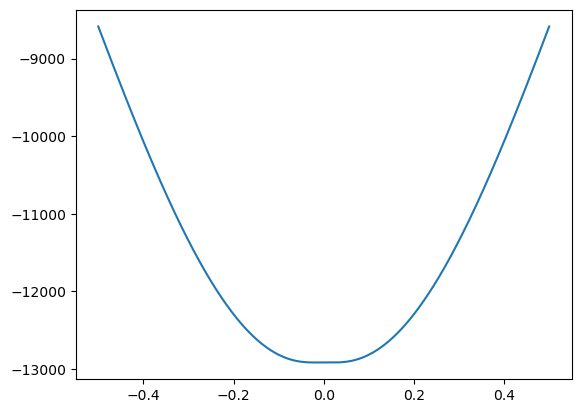

(-12916.81017273854, CartesianIndex(480, 1))

In [51]:
xdum = range(-0.5, 0.5, length = 1000) 
dis=0.06
σp_beam = exp.(-(xdum .- dis).^2)
σm_beam = exp.(-(xdum .+ dis).^2)
#σp_beam = 1 .-(xdum.-dis).^2
#σm_beam = 1 .-(xdum.+dis).^2
potentials,szexp= get_levels(σp_beam, σm_beam; Kmax = 2, offdiag = true, return_vecs = true)
plot(xdum,potentials[:,1])
findmin(potentials)


In [52]:
potentials[501,1]

-12916.192368504277

The next block gives an exact

In [331]:
dis=0.156
pol = [1,0,exp(-(2*dis)^2)]
pol = pol/norm(pol)
vals= normalized_polarization_eigenstates(toω(latwavelength/ a₀), pol; Kmax = 2, offdiag = false, return_vecs = true);
println("The critical distance is ",vals[17]*(1+exp(-0.3^2)^2))

The is -149651.59098403592


In [328]:
pol = [1,0,1]
pol = pol/norm(pol)
vals,vecs= normalized_polarization_eigenstates(toω(latwavelength/ a₀), pol; Kmax = 2, offdiag = true, return_vecs = true);
vals[1]*(2*exp(-dis^2)^2)

-149123.22184813058

In [148]:
xdum = range(-1, 1, length = 10) #20
σp_beam = cos.(π*xdum/2 .- π/24)
σm_beam = cos.(π*xdum/2 .+ π/24)

for (k, Kmax) ∈ enumerate([0:0;])
    potentials, szexp = get_levels(σp_beam, σm_beam; Kmax = Kmax, offdiag = true, return_vecs = true)
    for (i, p) ∈ enumerate(eachrow(potentials'))
        a = [xdum p]
        linecol = cat(a[1:(end-1), :], a[2:end, :], dims = 3)
        linecol = permutedims(linecol, [1, 3, 2])
        lc = LineCollection(linecol, colors = cmap.(szexp[:, i]/16.0 .+ 0.5), lw = 0.7)
        print(size(linecol))
    end
end

(9, 2, 2)(9, 2, 2)(9, 2, 2)(9, 2, 2)(9, 2, 2)(9, 2, 2)(9, 2, 2)(9, 2, 2)(9, 2, 2)(9, 2, 2)(9, 2, 2)(9, 2, 2)(9, 2, 2)(9, 2, 2)(9, 2, 2)(9, 2, 2)(9, 2, 2)

In [150]:
a=[-1 2 ; 0 9; 1 3]
linecol=cat(a[1:(end-1), :], a[2:end, :], dims = 3)
linecol = permutedims(linecol, [1, 3, 2])

2×2×2 Array{Int64, 3}:
[:, :, 1] =
 -1  0
  0  1

[:, :, 2] =
 2  9
 9  3

(4, 2, 2)[0.0, 0.0, 0.0, 1.0, 1.0]

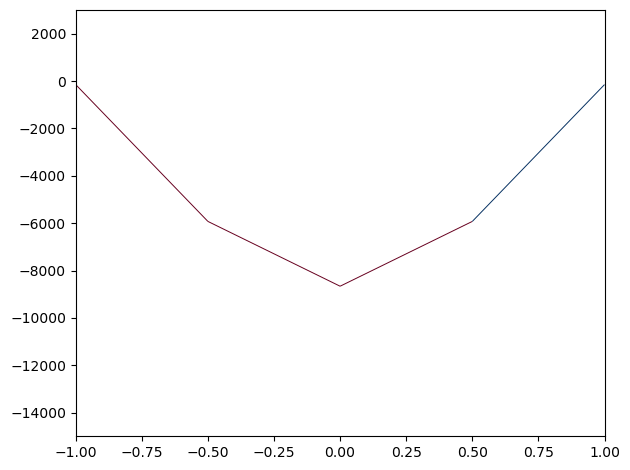

In [165]:
fig, ax = plt.subplots()
cmap = matplotlib.cm.get_cmap("RdBu");

xdum = range(-1, 1, length = 5) #20
σp_beam = cos.(π*xdum/2 .- π/24)
σm_beam = cos.(π*xdum/2 .+ π/24)

for (k, Kmax) ∈ enumerate([1:1;])
    potentials, szexp = get_levels(σp_beam, σm_beam; Kmax = Kmax, offdiag = true, return_vecs = true)
    for (i, p) ∈ enumerate(eachrow(potentials'[1:1,:]))
        a = [xdum p]
        #print(a)
        linecol = cat(a[1:(end-1), :], a[2:(end-0), :], dims = 3)
        linecol = permutedims(linecol, [1, 3, 2])
        print(size(linecol))
        lc = LineCollection(linecol, colors = cmap.(szexp[:, i]/16.0 .+ 0.5), lw = 0.7)
        ax.add_collection(lc)
        print(szexp[:, i]/16.0.+0.5)
    end
end

ax.set_xlim([-1, 1])
ax.set_ylim([-15000, 3000])
fig.tight_layout()
fig.subplots_adjust(hspace = 0.05, wspace = 0.05)



In [161]:
test2=[-1.0 -0.5; -0.5 0.0; 0.0 0.5; 0.5 1.0;;; -150.1616519933009 -5927.688443545914; -5927.688443545914 -8663.648670581038; -8663.648670581038 -5927.688443545914; -5927.688443545914 -150.1616519933009]
test2[4,:,2]

2-element Vector{Float64}:
 -5927.688443545914
  -150.1616519933009

[-8.0, -8.0, -8.0, -8.0, -8.0, 8.0, 8.0, 8.0, 8.0, 8.0]

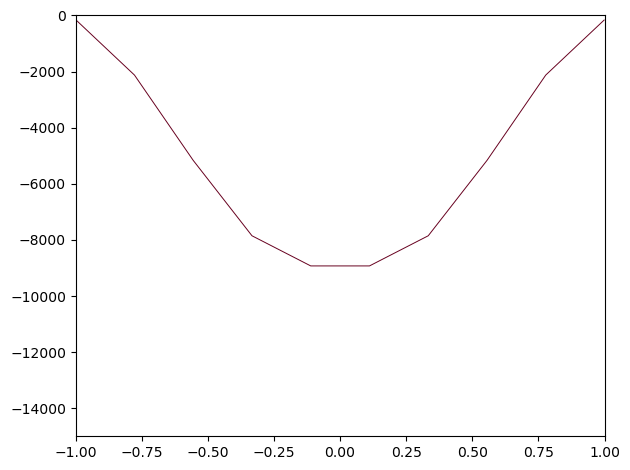

In [130]:
fig, ax = plt.subplots()
cmap = matplotlib.cm.get_cmap("RdBu");

xdum = range(-1, 1, length = 10) #20
σp_beam = cos.(π*xdum/2 .- π/24)
σm_beam = cos.(π*xdum/2 .+ π/24)

for (k, Kmax) ∈ enumerate([1:1;])
    potentials, szexp = get_levels(σp_beam, σm_beam; Kmax = Kmax, offdiag = true, return_vecs = true)
    for (i, p) ∈ enumerate(eachrow(potentials'[1:1,:]))
        test = zeros(1,length(xdum),2)
        test[1,:,1]=xdum
        test[1,:,2]=p
        lc = LineCollection(test, colors = cmap.(szexp[:, i]/16.0 .+ 0.5), lw = 0.7)
        ax.add_collection(lc)
        #print(test)
        print(szexp[:, 1])
    end
end

ax.set_xlim([-1, 1])
ax.set_ylim([-15000, 0])
fig.tight_layout()
fig.subplots_adjust(hspace = 0.05, wspace = 0.05)



In [54]:
120/370

0.32432432432432434